# Evaluate parallelisation performance for audio download and upload

This script evaluates the time taken for different cluster configurations and partitions

We use a test data set of just 15 videos of variable length (42 seconds to 12 minutes)

## Code to evaluate numerically
Run this code for different cluster configurations. We compare using 2 workers to 3 workers, i.e. specifying "--num-workers 2" vs "--num-workers 3".

The csv files with the time taken are saved.

In [9]:
import datetime
import isodate
import pandas as pd
from pyspark.sql import SparkSession
import subprocess
import time

numworkers = 3
BUCKET_NAME = "st446-w9-stine"

In [2]:
# Create a Spark session
spark = SparkSession.builder \
    .appName("parallel_audio_download") \
    .getOrCreate()

In [3]:
# Define the local and HDFS paths for the CSV file
local_path = '/urls_combined.csv'
hdfs_path = '/user/root/urls_combined.csv'  # This will save the file in /user/root on HDFS

# Command to upload the file to HDFS
put_cmd = ['hdfs', 'dfs', '-put', local_path, hdfs_path]

# Execute the command
try:
    subprocess.check_call(put_cmd)
    print("File uploaded to HDFS successfully.")
except subprocess.CalledProcessError as e:
    print("Failed to upload file:", e)


File uploaded to HDFS successfully.


In [4]:
# Read the CSV file from HDFS into a DataFrame
df = spark.read.csv('/user/root/urls_combined.csv', header=True, inferSchema=True).limit(15)
pdf = df.toPandas()

# Show the first few rows of the DataFrame
df.show()

+--------------------+-------------------+--------+--------------------+------+--------+
|               Title|               Date|Duration|                 URL|Source|In_April|
+--------------------+-------------------+--------+--------------------+------+--------+
|Explosions in Ira...|2024-04-19 00:00:00| 0:00:57|https://www.youtu...|   CNN|    true|
|Israel carries ou...|2024-04-19 00:00:00| 0:00:42|https://www.youtu...|   CNN|    true|
|House passes fore...|2024-04-20 00:00:00| 0:00:58|https://www.youtu...|   CNN|    true|
|Explosions over s...|2024-04-14 00:00:00| 0:07:44|https://www.youtu...|   CNN|    true|
|Dramatic video sh...|2024-04-14 00:00:00| 0:07:46|https://www.youtu...|   CNN|    true|
|Iran has launched...|2024-04-13 00:00:00| 0:08:28|https://www.youtu...|   CNN|    true|
|Iran accuses Isra...|2024-04-01 00:00:00| 0:09:09|https://www.youtu...|   CNN|    true|
|Satellite images ...|2024-04-20 00:00:00| 0:08:33|https://www.youtu...|   CNN|    true|
|Ex-CIA director m...

In [5]:
pdf

,Title,Date,Duration,URL,Source,In_April
0,Explosions in Iran as Israel vows retaliation ...,2024-04-19,0:00:57,https://www.youtube.com/watch?v=bQRYjWIDCkM,CNN,True
1,"Israel carries out strike against Iran, US off...",2024-04-19,0:00:42,https://www.youtube.com/watch?v=CwJdNZ72M5U,CNN,True
2,House passes foreign aid for Ukraine and Israel,2024-04-20,0:00:58,https://www.youtube.com/watch?v=fee7eSNW58c,CNN,True
3,Explosions over skies of Israel as barrage of ...,2024-04-14,0:07:44,https://www.youtube.com/watch?v=g1vAkZx2xDg,CNN,True
4,Dramatic video shows outgoing Hezbollah rocket...,2024-04-14,0:07:46,https://www.youtube.com/watch?v=lLBzubEayvo,CNN,True
5,Iran has launched more than 100 drones toward ...,2024-04-13,0:08:28,https://www.youtube.com/watch?v=TZviLs11jz0,CNN,True
6,Iran accuses Israel of killing top commander i...,2024-04-01,0:09:09,https://www.youtube.com/watch?v=UX-_To2fh50,CNN,True
7,Satellite images show minimal damage after Isr...,2024-04-20,0:08:33,https://www.youtube.com/watch?v=u62BCkSMNCY,CNN,True
8,Ex-CIA director makes prediction about Netanya...,2024-04-04,0:08:07,https://www.youtube.com/watch?v=ScSEYvUafMI,CNN,True
9,USC cancels pro-Palestinian valedictorian's co...,2024-04-17,0:06:56,https://www.youtube.com/watch?v=uA8KqvAJJmo,CNN,True


In [13]:
import os
import subprocess
from pytube import YouTube
#from google.cloud import storage

def download_audio(url):
    try:
        yt = YouTube(url)
        audio_stream = yt.streams.filter(only_audio=True).order_by('abr').desc().first()
        filename = audio_stream.download()
        return filename
    except Exception as e:
        print(f"Failed to download audio from {url}. Reason: {e}")
        return None

def adjust_audio(input_audio_path, output_audio_path, target_sample_rate=44100, channels=1):
    if not output_audio_path.endswith('.wav'):
        output_audio_path = os.path.splitext(output_audio_path)[0] + '.wav'
    
    command = [
        "ffmpeg",
        "-i", input_audio_path,          
        "-ar", str(target_sample_rate),   
        "-ac", str(channels),           
        "-y",                            
        output_audio_path                 
    ]
    try:
        subprocess.run(command, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        return output_audio_path
    except subprocess.CalledProcessError as e:
        print(f"Failed to adjust audio properties: {e.stderr.decode()}")


def upload_to_gcs(local_file_path, bucket_name, gcs_file_path):
    try:
        subprocess.run(
            ["gsutil", "cp", local_file_path, f"gs://{bucket_name}/{gcs_file_path}"],
            check=True,
            capture_output=True
        )
    except subprocess.CalledProcessError as e:
        print(f"Failed to upload {local_file_path} to GCS: {e.stderr.decode()}")
    
def download_upload_audio(row):
    video_url = row['URL']
    try:
        audio_path = download_audio(video_url)
        adjusted_audio_path = audio_path.replace('.mp4', '_adjusted.wav')
        adjusted_audio_path = adjust_audio(audio_path, adjusted_audio_path, 16000, 1)
        if adjusted_audio_path:
            gcs_audio_filename = os.path.basename(adjusted_audio_path)
            upload_to_gcs(adjusted_audio_path, BUCKET_NAME, gcs_audio_filename)
            return True
    except Exception as e:
        print(f"Error processing {video_url}: {str(e)}")
        return False
    
def measure_performance(rdd, num_partitions):
    # Repartition RDD
    temp_rdd = rdd.repartition(num_partitions)
    
    # Measure performance
    start_time = time.time()
    # Assume 'do_all' is a function you've defined that applies to each element of the RDD
    results = temp_rdd.map(download_upload_audio).collect()
    end_time = time.time()
    
    # Calculate and return the processing time
    spark_time = end_time - start_time
    return spark_time

In [8]:
# Pandas time for baseline
start_time = time.time()
results = pdf.apply(download_upload_audio, axis=1)
end_time = time.time()
pandas_time = end_time - start_time
print(f"Pandas processing time: {pandas_time} seconds")

https://www.youtube.com/watch?v=bQRYjWIDCkM
True
https://www.youtube.com/watch?v=CwJdNZ72M5U
True
https://www.youtube.com/watch?v=fee7eSNW58c
True
https://www.youtube.com/watch?v=g1vAkZx2xDg
True
https://www.youtube.com/watch?v=lLBzubEayvo
True
https://www.youtube.com/watch?v=TZviLs11jz0
True
https://www.youtube.com/watch?v=UX-_To2fh50
True
https://www.youtube.com/watch?v=u62BCkSMNCY
True
https://www.youtube.com/watch?v=ScSEYvUafMI
True
https://www.youtube.com/watch?v=uA8KqvAJJmo
True
https://www.youtube.com/watch?v=LCSTmqiEx6o
True
https://www.youtube.com/watch?v=X-I0DY1VXGE
True
https://www.youtube.com/watch?v=F22D0jCGdLU
True
https://www.youtube.com/watch?v=RpbdIAWRsR0
True
https://www.youtube.com/watch?v=9OYKd1reSPc
True
Pandas processing time: 90.01475191116333 seconds


In [10]:
# Convert df to rdd
vid_rdd = df.rdd

# List of different partition counts to test
partition_sizes = [1, 2, 4, 6, 8, 10, 12, 14]

# Dictionary to hold results
performance_results = {}

# Measure performance for each partition size
for size in partition_sizes:
    performance_results[size] = measure_performance(vid_rdd, size)

In [11]:
# Convert dictionary to DataFrame
results_df = pd.DataFrame(list(performance_results.items()), columns=['Partitions', 'TimeInSeconds'])
results_df['Workers'] = numworkers

# Show results
results_df

,Partitions,TimeInSeconds,Workers
0,1,57.003162,3
1,2,33.021318,3
2,4,36.747638,3
3,6,33.190706,3
4,8,32.559235,3
5,10,32.824196,3
6,12,32.703774,3
7,14,35.721064,3


In [12]:
# Save to CSV
results_df.to_csv(f'results{numworkers}.csv', index=False)

## Making plot to compare results

In [28]:
# Reading the data
df1 = pd.read_csv('results2.csv')
df2 = pd.read_csv('results3.csv')
# Adding Pandas baseline
df3 = df2
df3['Workers'] = 'Pandas'
df3['TimeInSeconds'] = 96
df2 = pd.read_csv('results3.csv')
df = pd.concat([df1, df2, df3], axis=0)
df

,Partitions,TimeInSeconds,Workers
0,1,50.152203,2
1,2,41.558110,2
2,4,37.473089,2
3,6,36.143872,2
4,8,37.426349,2
5,10,36.622191,2
6,12,36.836048,2
7,14,36.723303,2
0,1,57.003162,3
1,2,33.021318,3


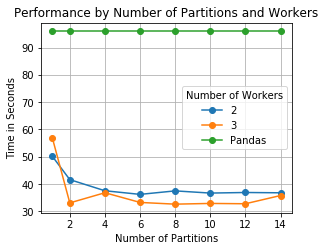

In [30]:
# Plotting the results

import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(4.5, 3.5)) 
for label, grp in df.groupby('Workers'):
    grp.plot(x='Partitions', y='TimeInSeconds', ax=ax, label=f'{label}', marker='o', linestyle='-')

plt.title('Performance by Number of Partitions and Workers')
plt.xlabel('Number of Partitions')
plt.ylabel('Time in Seconds')
plt.legend(title='Number of Workers')
plt.grid(True)
plt.savefig('performance_plot.pdf')
plt.show()